In [1]:
import pandas as pd
import numpy as np
np.__version__
import matplotlib.pyplot as plt
_FOLDER = "../data/"
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import \
    KFold, RepeatedKFold, GridSearchCV, \
    cross_validate, train_test_split

import json

In [2]:
def createResponseCurve(iD,model, xValues, yValues, predicted = False):
    plt.scatter(xValues, yValues)
    plt.title(model + " " + iD)
    plt.xlabel("Scaled dosage")
    if(predicted):
        plt.ylabel("Predicted Normalised response")
    else:
        plt.ylabel("Normalised response")
    plt.show()


with open(_FOLDER + 'dataSplit.json') as json_file:
    trainTestSplit = json.load(json_file)

In [3]:
drugProfiles = pd.read_csv(_FOLDER+'filteredResponsesWithCCLAndParams.csv')
drugProfiles

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,HDQ-P1,1290922,344,344_1290922,20.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
1,HDQ-P1,1290922,136,136_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
2,HDQ-P1,1290922,170,170_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
3,NMC-G1,908449,170,170_908449,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
4,NMC-G1,908449,331,331_908449,10.24,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,TC-YIK,946357,1011,1011_946357,2.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5580,MKN45,925340,1149,1149_925340,5.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5581,EC-GI-10,753555,1004,1004_753555,0.10,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5582,IGROV-1,905968,1031,1031_905968,0.20,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0


In [4]:
len(trainTestSplit.keys())

88

In [21]:
# filterPlateau = filterPlateau[~filterPlateau['DRUG_ID'].isin(toDropDrugs)]
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
param_labels = ['param_'+str(i) for i in range(1,5)]
pred_param_labels = ['pred_param_'+str(i) for i in range(1,5)]
notIncludeColumns = ['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID','MAX_CONC'] + resp_labels

fullPredLabels = ['DRUG_COSMICID'] + pred_param_labels
ridgeResults = pd.DataFrame(columns=fullPredLabels)
lassoResults = pd.DataFrame(columns=fullPredLabels)
combinedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns= ['DRUG_COSMICID']+ param_labels)
df = None
for drugId in trainTestSplit.keys():
    drugProfile = drugProfiles[drugProfiles['DRUG_ID'] == int(drugId)]
    trainData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][0])]
    testData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][1])]
    testDataCosmicIds = np.array(testData['DRUGID_COSMICID'])
    notXValuesFilter = resp_labels + notIncludeColumns + conc_labels + param_labels
    trainXValues = trainData.drop(columns = notXValuesFilter)
    trainYValues = trainData[param_labels]

    trainX = trainXValues.reset_index(drop=True).to_numpy()
    trainY = trainYValues.reset_index(drop=True).to_numpy()

    testXValues = testData.drop(columns = notXValuesFilter)
    testYValues = testData[param_labels]

    testX = testXValues.reset_index(drop=True).to_numpy()
    testY = testYValues.reset_index(drop=True).to_numpy()

    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
#     ridge_alphas = np.linspace(0, 600, 40)
    ridge_alphas = np.linspace(0, 0.1, 10)
    ridge = Ridge()
    grid = dict()
    grid['alpha'] = ridge_alphas
    gscv = GridSearchCV( \
        ridge, grid, scoring='neg_mean_absolute_error', \
        cv=cv, n_jobs=-1)
    results = gscv.fit(trainX, trainY)
    print(results.best_params_)

    ridge = Ridge(alpha=results.best_params_['alpha'])
    ridge.fit(trainX, trainY)
    pred_train = ridge.predict(trainX)
    pred_test= ridge.predict(testX)
    resultsRidge = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    resultsRidge[pred_param_labels] = pred_test
    ridgeResults = ridgeResults.append(resultsRidge,ignore_index=True,sort=False)

    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
#     lasso_alphas = np.linspace(0, 7, 10)
    lasso_alphas = np.linspace(0, 0.1, 10)
    lasso = Lasso()
    grid = dict()
    grid['alpha'] = lasso_alphas
    gscv = GridSearchCV( \
        lasso, grid, scoring='neg_mean_absolute_error', \
        cv=cv, n_jobs=-1)
    results = gscv.fit(trainX, trainY)
    print(results.best_params_)

    lasso = Lasso(alpha=results.best_params_['alpha'])
    lasso.fit(trainX, trainY)
    pred_trainL = lasso.predict(trainX)
    pred_testL= lasso.predict(testX)
    resultsLasso = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    resultsLasso[pred_param_labels] = pred_testL
    lassoResults = lassoResults.append(resultsLasso,ignore_index=True,sort=False)

    trueResult = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    trueResult[param_labels] = testY
    trueResults = trueResults.append(trueResult,ignore_index=True,sort=False)


    combinedResult = np.add(pred_test, pred_testL)
    divide2 = lambda i: float(i) / 2

    vectorized_divide2 = np.vectorize(divide2)

    combinedResult = np.asmatrix(vectorized_divide2(combinedResult))
    resultsComb = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    resultsComb[pred_param_labels] = combinedResult
    combinedResults = combinedResults.append(resultsComb,ignore_index=True,sort=False)



{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.08888888888888889}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4570.399388626733, tolerance: 602.4840967409245
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4570.399388626733, tolerance: 602.4840967409245
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4323.116562274714, tolerance: 3062.660193857104
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4323.116562274714, tolerance: 3062.660193857104
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.0}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.25869849443296, tolerance: 2.9079951193167015
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163.90433875051082, tolerance: 16.55993138511064
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1252.7228068230856, tolerance: 520.2120658136399
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

{'alpha': 0.011111111111111112}
{'alpha': 0.1}
{'alpha': 0.011111111111111112}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125132.99576555699, tolerance: 4351.169070065608
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125132.99576555699, tolerance: 4351.169070065608
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAl

{'alpha': 0.0}
{'alpha': 0.0}
{'alpha': 0.07777777777777778}
{'alpha': 0.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


{'alpha': 0.06666666666666667}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.0}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.141868493224706, tolerance: 3.0628349359433606
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139.81860020202512, tolerance: 25.991745700554535
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.141868493224706, tolerance: 3.0628349359433606
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

{'alpha': 0.011111111111111112}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2102.6615812166106, tolerance: 1215.630690311239
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2102.6615812166106, tolerance: 1215.630690311239
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219.3684798127902, tolerance: 192.6229591002464
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219.3684798127902, tolerance: 192.6229591002464
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.03333333333333333}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.0}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.05383620737574, tolerance: 9.405884710964095
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359.9339931944784, tolerance: 38.70791116830076
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9653.03349314459, tolerance: 1559.9196861859232
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

{'alpha': 0.011111111111111112}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359.9339931944784, tolerance: 38.70791116830076
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9653.03349314459, tolerance: 1559.9196861859232
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.011111111111111112}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.0}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.0}
{'alpha': 0.1}
{'alpha': 0.06666666666666667}
{'alpha': 0.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.21115e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.21115e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


{'alpha': 0.011111111111111112}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.52195253755684, tolerance: 30.315128675459864
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.52195253755684, tolerance: 30.315128675459864
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.02712e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.02712e-17): result may not be accurate.
  dual_coef = linalg.solv

{'alpha': 0.044444444444444446}
{'alpha': 0.0}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.0}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104260.46686679275, tolerance: 21641.70331321676
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104260.46686679275, tolerance: 21641.70331321676
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.011111111111111112}
{'alpha': 0.1}
{'alpha': 0.011111111111111112}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.044444444444444446}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.0}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.03333333333333333}
{'alpha': 0.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.14944e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.14944e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.525516775731436, tolerance: 3.497244166974545
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.525516775731436, tolerance: 3.497244166974545
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.011111111111111112}
{'alpha': 0.1}
{'alpha': 0.08888888888888889}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserW

{'alpha': 0.0}
{'alpha': 0.0}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.45746629875195, tolerance: 10.16269188823569
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.45746629875195, tolerance: 10.16269188823569
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.6529e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.6529e-18): result may not be accurate.
  dual_coef = linalg.solve(K,

{'alpha': 0.011111111111111112}
{'alpha': 0.0}
{'alpha': 0.011111111111111112}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: U

{'alpha': 0.0}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.0}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.0}
{'alpha': 0.1}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.0}
{'alpha': 0.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.0}
{'alpha': 0.1}
{'alpha': 0.1}
{'alpha': 0.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.2878e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.2878e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does no

{'alpha': 0.0}
{'alpha': 0.1}
{'alpha': 0.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-21-8cab97ed6486>:65: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


In [22]:
lassoResults

,DRUG_COSMICID,pred_param_1,pred_param_2,pred_param_3,pred_param_4
0,344_910851,-14.768345,0.998760,26.839528,-0.026728
1,344_717431,-7.886457,0.998760,35.834216,-0.026728
2,344_910925,14.615991,0.998760,-49.704941,-0.026728
3,344_908457,-20.821359,0.998760,-6.501579,-0.026728
4,344_910853,-9.000013,0.998760,43.394285,-0.026728
...,...,...,...,...,...
1150,330_910688,-3.801606,0.970703,7.601086,0.197611
1151,330_908146,-7.418834,1.006637,13.846179,1.011145
1152,330_949088,-3.491516,0.973220,7.789739,-0.051634
1153,1058_753531,-1.734232,1.004027,4.527408,-0.015901


In [23]:
ridgeResults

,DRUG_COSMICID,pred_param_1,pred_param_2,pred_param_3,pred_param_4
0,344_910851,-37.762935,0.965850,95.485471,0.030885
1,344_717431,-36.424377,0.986589,58.772381,-0.047023
2,344_910925,-2.099124,0.940652,6.610399,-0.079135
3,344_908457,-33.911407,1.018169,31.106745,0.069242
4,344_910853,-15.356437,0.977817,61.265332,0.119835
...,...,...,...,...,...
1150,330_910688,-4.677134,0.992349,10.790022,0.440160
1151,330_908146,-2.686476,1.001687,6.135182,-0.405924
1152,330_949088,-2.567558,0.990297,5.413283,-0.347693
1153,1058_753531,-2.070608,0.995777,4.827072,0.019187


In [24]:
combinedResults

,DRUG_COSMICID,pred_param_1,pred_param_2,pred_param_3,pred_param_4
0,344_910851,-26.265640,0.982305,61.162499,0.002078
1,344_717431,-22.155417,0.992674,47.303299,-0.036875
2,344_910925,6.258433,0.969706,-21.547271,-0.052931
3,344_908457,-27.366383,1.008465,12.302583,0.021257
4,344_910853,-12.178225,0.988289,52.329809,0.046554
...,...,...,...,...,...
1150,330_910688,-4.239370,0.981526,9.195554,0.318885
1151,330_908146,-5.052655,1.004162,9.990681,0.302610
1152,330_949088,-3.029537,0.981758,6.601511,-0.199663
1153,1058_753531,-1.902420,0.999902,4.677240,0.001643


In [25]:
trueResults

,DRUG_COSMICID,param_1,param_2,param_3,param_4
0,344_910851,-16.424564,0.958175,23.736499,0.222941
1,344_717431,-9.979214,1.054327,25.806256,0.003961
2,344_910925,-19.679407,0.997509,25.848962,0.004848
3,344_908457,-2.704682,0.995417,6.327667,-0.086482
4,344_910853,-5.761424,0.934020,7.109135,-0.029411
...,...,...,...,...,...
1150,330_910688,-1.897305,0.981859,7.344160,-0.130963
1151,330_908146,-14.114180,1.023774,33.474336,0.124503
1152,330_949088,-4.187456,0.939049,7.541476,0.058395
1153,1058_753531,-2.474842,1.031552,5.599440,0.051272


In [26]:
ridgeResults = ridgeResults.drop_duplicates()
lassoResults = lassoResults.drop_duplicates()
combinedResults = combinedResults.drop_duplicates()

In [27]:
def ll4_R(x, c, a, b, d):
    return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)

def showTestPredResponses(drugIdCosmic):
    sampleRidge = ridgeResults[ridgeResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    ridgeY = sampleRidge[pred_param_labels]
    ridgeY = np.array(ridgeY[pred_param_labels]).squeeze()
    sampleLasso = lassoResults[ridgeResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    lassoY = sampleLasso[pred_param_labels]
    lassoY = np.array(lassoY[pred_param_labels]).squeeze()
    sampleComb = combinedResults[ridgeResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    combY = sampleComb[pred_param_labels]
    combY = np.array(combY[pred_param_labels]).squeeze()
    trueY = trueResults[trueResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    trueY = np.array(trueY[param_labels]).squeeze()
    print(trueY)
    xValues = np.linspace(0.0, 1.0, 100)
    
    plt.title(drugIdCosmic + " dosage against response")
    plt.plot(xValues, ll4_R(xValues, *trueY), color="b", label = "True")
    plt.plot(xValues, ll4_R(xValues, *ridgeY), color="g", label = "Ridge")
    plt.plot(xValues, ll4_R(xValues, *lassoY), color="r", label = "Lasso")
    plt.plot(xValues, ll4_R(xValues, *combY), color="y", label = "Combined")
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.legend()
    plt.show()

[-9.12772914  0.96793451 14.81668286  0.1688162 ]


<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


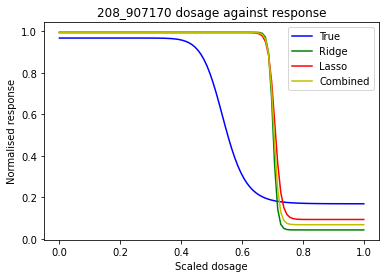

[-4.11787921  0.93311657  7.72929482 -0.01763427]


<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


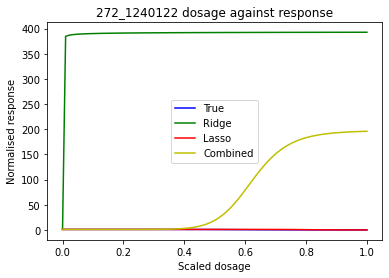

[-4.58654936  0.97038058  8.04171309  0.15725474]


<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


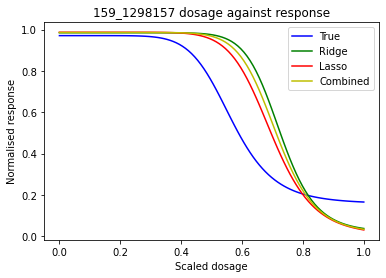

[-10.56815109   0.98788046   7.7356094    0.05397964]


<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


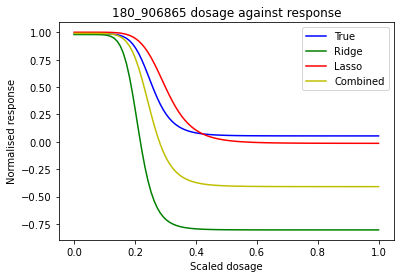

[-2.05325529e+01  9.75347385e-01  2.01574018e+01  7.65233228e-03]


<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


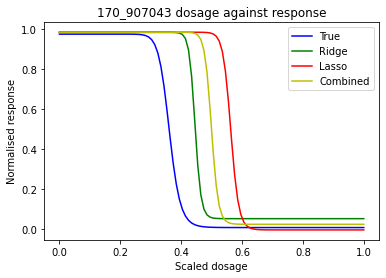

<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


[-4.46017482e+00  1.00482040e+00  9.31209293e+00 -8.81311705e-03]


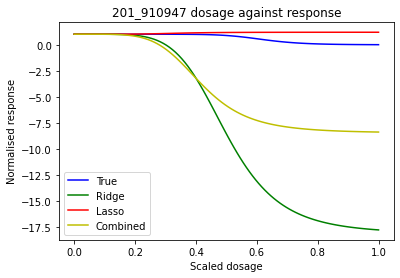

[-7.90200907e+00  9.57580865e-01  2.23535323e+01  1.44997725e-02]


<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


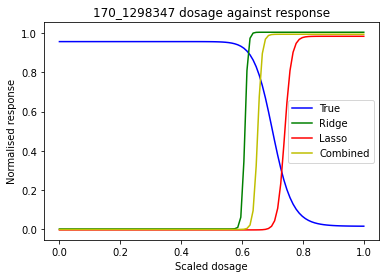

[-6.16039278e+01  1.03477229e+00  3.42258384e+02  4.96317304e-02]


<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


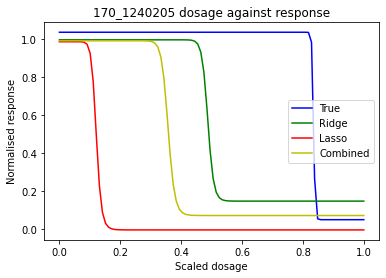

<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


[-5.46752768  0.99399261  4.81362707  0.06441134]


<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-27-6e4e3105d331>:2: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


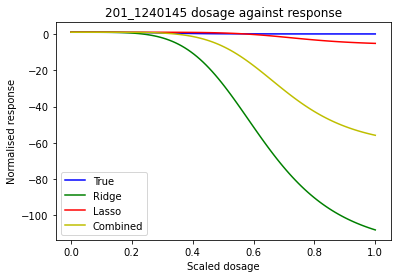

In [28]:
max_int = len(trueResults.index)
rand_int = np.random.randint(0, max_int, 9)
for index in rand_int:
    showTestPredResponses(trueResults.loc[index]['DRUG_COSMICID'])